# Unit 2 Portfolio Project
## Predictive Modeling with Spotify Data
Ryan Fikejs - *Data Science, Lambda School DS 26*

### Module 3 Tasks (v1.2)

*Continue to clean and explore your data. Make exploratory visualizations*



*Fit a model. Does it beat your baseline?*

Yes.

*Try XGBoost*

Didn't perform as well on first run, but I will take out some features and do some more tuning.

*Get your model's permutation importances.*


**Notes:**

• Added <inplace=True> to the part of the wrangle function dropping 'popularity' feature 

• Considering looking at releases from the past 20 - 50 years as I think that would still be a relevant set of data to learn from.

### Module 2 (Tasks v1.1)

*Continue to clean and explore your data.*

Data is very clean, but I did decide on a few columns to create and drop.

*For the evaluation metric you chose, what score would you get just by guessing?*

For this afternoon I just went ahead with the accuracy score, but tonight I will experiment with others.

*Can you make a fast, first model that beats guessing?*

I did, but it may be too good. Further investigating tonight


**Notes:**

• I did change my target array to five classes / buckets (100+ is too many for what I'm trying to do)

• I may change my target to a binary classification

• I may consider trying to do this task for a more specific genre in order to work with a smaller data set.

### Module 1 Tasks

*Choose your target. Which column in your tabular dataset will you predict?*

My target is the popularity rating.

*Is your problem regression or classification?*

Currently considering it a large scale classification problem, (there are 101 classes involved) wondering if I should cut it down as was done in the burrito problem and say a popularity rating of 80-100 is very popular, below 80 is not very popular.

*How is your target distributed?*

*Classification: How many classes? Are the classes imbalanced?*

101 classes very imbalanced.

*Choose your evaluation metric(s).*

*Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that 
range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?*

No, I will likely be using F1-score and AUC of ROC. (Maybe categorical crossentropy if I learn enough about it and it makes sense to, I heard it's good for generalizing multiclass problems, but is typically used with neural networks.)

*Choose which observations you will use to train, validate, and test your model.*

I will use a random selection via train test split to separate atraining set and cross validation for training and validation.

*Are some observations outliers? Will you exclude them?*

No

*Will you do a random split or a time-based split?*

Random split

*Begin to clean and explore your data.*

*Begin to choose which features, if any, to exclude. Would some features "leak" future information?*

I will leave out song ID and name. I may keep either artists or id_artists.

## I. Wrangle Data

### Import packages

In [16]:
# For data frame manipulation
import pandas as pd

# For more math horsepower
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For pipeline and model building
# Pipeline
from sklearn.pipeline import make_pipeline
# Transformers
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
# For random forest
from sklearn.ensemble import RandomForestClassifier
# For gradient boost
from xgboost import XGBClassifier
# For splitting data, scoring, tuning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# For scoring and evaluating results
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
# For determining most important features
from sklearn.inspection import permutation_importance

## Wrangle Data

In [2]:
def wrangle(file_path):
    df = pd.read_csv(file_path,
                    parse_dates=['release_date'])
    
    # Split release_date into day, month, year, then drop it
    df['released_year'] = df['release_date'].dt.year
    df['released_month'] = df['release_date'].dt.month
    df['released_day'] = df['release_date'].dt.day
    df.drop(columns=['release_date'], inplace=True)
    
    # Make new buckets for prediction
    df['popular'] = [0 if r<19 else 1 if r<39 else 2 if r<59 else 3 if r<79 else 4 for r in df['popularity']]
    df.drop(columns='popularity', inplace=True)
    
    # Drop columns I suspect do not imfluence the target, or are redundant
    df.drop(columns=['id', 'name', 'artists'], inplace=True)
    
    return df

In [3]:
df = wrangle('data/tracks.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       586672 non-null  int64  
 1   explicit          586672 non-null  int64  
 2   id_artists        586672 non-null  object 
 3   danceability      586672 non-null  float64
 4   energy            586672 non-null  float64
 5   key               586672 non-null  int64  
 6   loudness          586672 non-null  float64
 7   mode              586672 non-null  int64  
 8   speechiness       586672 non-null  float64
 9   acousticness      586672 non-null  float64
 10  instrumentalness  586672 non-null  float64
 11  liveness          586672 non-null  float64
 12  valence           586672 non-null  float64
 13  tempo             586672 non-null  float64
 14  time_signature    586672 non-null  int64  
 15  released_year     586672 non-null  int64  
 16  released_month    58

1    219413
0    199566
2    136353
3     30107
4      1233
Name: popular, dtype: int64


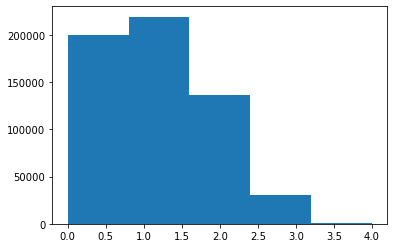

In [5]:
# Look at the distribution of the target
class_dist = df['popular']
print(class_dist.value_counts())
plt.hist(class_dist, bins=5);

In [6]:
df.nunique()

duration_ms         123122
explicit                 2
id_artists          115062
danceability          1285
energy                2571
key                     12
loudness             29196
mode                     2
speechiness           1655
acousticness          5217
instrumentalness      5402
liveness              1782
valence               1805
tempo               122706
time_signature           5
released_year          101
released_month          12
released_day            31
popular                  5
dtype: int64

In [7]:
df.isnull().sum()

duration_ms         0
explicit            0
id_artists          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
released_year       0
released_month      0
released_day        0
popular             0
dtype: int64

## Split Data

In [8]:
# Establish the target and split the data accordingly
target = 'popular'
X_ = df.drop(columns=target)
y_ = df[target]

In [9]:
# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X_, y_, train_size=0.8, random_state=73)

# Further split training set into training and 
# validation for initial model
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=37)

## Establish a Baseline

In [10]:
baseline = y.value_counts(normalize=True).max()
print(f'Baseline: {baseline}')

Baseline: 0.3747413905147048


## Build a Model

### Random Forest (bagging model)

In [11]:
# Make a model using a random forest
model_rf = make_pipeline(
            OrdinalEncoder(),
            StandardScaler(),
            RandomForestClassifier(random_state=37, n_jobs=-2))

# Fit the random forest model
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['7Ch5fs1WRyYzlkiclW5tFJ']        1
['2tRsMl4eGxwoNabM08Dm4I']        2
['48YxSlb23RAaCd4RyHcV9V']        3
['7rcYk7wXrIQYA2qBccfscc']        4
['2clfvqAuuKp7PEhl6ZadTl']        5
                              ...  
['7AfDbA1rEHwRhzPH6jHSUE']    88316
['66BpLv7bc0OLbr50D1cnGS']    88317
['2ZVhkGdeedqMVD3oQM0O6N']    88318
['7xYxgSJaIf7yOFLmknYX38']    88319
NaN                              -2
Length: 88320, dtype: int64}])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-2, random_state=37))])

### XGBoost (boosting model)

In [19]:
# Make a boosted model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators=36, random_state=73, n_jobs=-2)
)

# Fit the boosted model
model_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['7Ch5fs1WRyYzlkiclW5tFJ']        1
['2tRsMl4eGxwoNabM08Dm4I']        2
['48YxSlb23RAaCd4RyHcV9V']        3
['7rcYk7wXrIQYA2qBccfscc']        4
['2clfvqAuuKp7PEhl6ZadTl']        5
                              ...  
['7AfDbA1rEHwRhzPH6jHSUE']    88316
['66BpLv7bc0OLbr50D1cnGS']    88317
['2ZVhkGdeedqMVD3oQ...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=36,
                               n_jobs=-2, num_parallel_tree=1,
             

## Check Metrics

In [12]:
# Accuracy scores for random forest model
print(accuracy_score(y_train, model_rf.predict(X_train)))
print(accuracy_score(y_val, model_rf.predict(X_val)))

0.9963405767187171
0.6127753867132569


In [20]:
# Accuracy scores for gradient boost model
print(accuracy_score(y_train, model_xgb.predict(X_train)))
print(accuracy_score(y_val, model_xgb.predict(X_val)))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.6108520277306515
0.5937593216005455


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [13]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.78      0.66      0.72     31957
           1       0.56      0.73      0.63     35115
           2       0.53      0.46      0.49     21732
           3       0.45      0.16      0.24      4870
           4       0.14      0.02      0.04       194

    accuracy                           0.61     93868
   macro avg       0.49      0.41      0.42     93868
weighted avg       0.62      0.61      0.61     93868



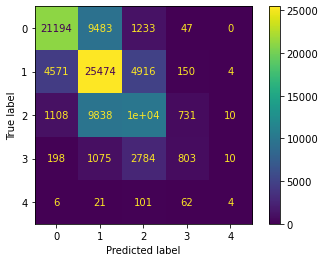

In [14]:
rf_val_cmatrix = plot_confusion_matrix(model_rf, X_val, y_val,)
rf_val_cmatrix;

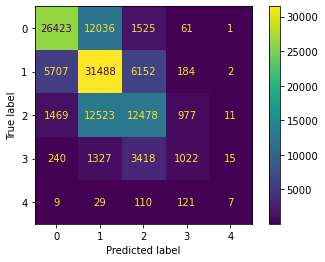

In [15]:
rf_test_cmatrix = plot_confusion_matrix(model_rf, X_test, y_test,)
rf_test_cmatrix;

## Tune Model

### Permutation Importances (to negate features in wrangle)

In [21]:
# Calculate permutation importances
perm_imp = permutation_importance(
    model_xgb,
    X_val,
    y_val,
    n_repeats=8,
    n_jobs=-2,
    random_state=41)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


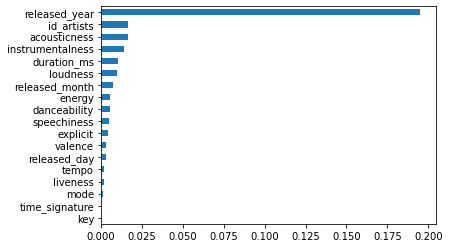

In [27]:
# Plot the permutation importances

# Create a data frame of the importances and feature names
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}
imp_df = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

# Plot a bar chart
imp_df['imp_mean'].plot(kind='barh');

### Hyper parameter tuning

In [28]:
# Do a randomized search to start the tuning process

# Setup empty results list
results = []

# Recall the pipeline(s)
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(random_state=73)
)

# Set a dictionary of the parameters to test
params = {
    'xgbclassifier__max_depth': np.arange(14, 40, 2),
    'xgbclassifier__n_estimators': np.arange(25, 150, 5),
    'xgbclassifier__learning_rate': np.arange(0.01, 0.11, 0.01),
    'xgbclassifier__gamma': np.arange(0.0, 1.1, 0.1),
    'xgbclassifier__reg_alpha': np.arange(0.0, 1.1, 0.1),
}

# Instatiate a RandomizedSearchCV model 
model_rs = RandomizedSearchCV(model_xgb, params, n_iter=5, n_jobs=-2, verbose=3)

# Store some results to choose from and then run through the model at the top
model_rs.fit(X_train, y_train)
val_acc = accuracy_score(y_val, model_rs.predict(X_val))
results.append((model_rs.best_params_, val_acc))

# Compare results
print(model_rs.best_params_, val_acc)
results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of  25 | elapsed: 14.5min remaining: 57.8min
[Parallel(n_jobs=-2)]: Done  14 out of  25 | elapsed: 44.2min remaining: 34.7min
[Parallel(n_jobs=-2)]: Done  23 out of  25 | elapsed: 53.2min remaining:  4.6min
[Parallel(n_jobs=-2)]: Done  25 out of  25 | elapsed: 53.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'xgbclassifier__reg_alpha': 0.8, 'xgbclassifier__n_estimators': 110, 'xgbclassifier__max_depth': 26, 'xgbclassifier__learning_rate': 0.060000000000000005, 'xgbclassifier__gamma': 0.1} 0.6225870371159501


[({'xgbclassifier__reg_alpha': 0.8,
   'xgbclassifier__n_estimators': 110,
   'xgbclassifier__max_depth': 26,
   'xgbclassifier__learning_rate': 0.060000000000000005,
   'xgbclassifier__gamma': 0.1},
  0.6225870371159501)]

## Communicate Results

The model improved with a random search, but I really should have gone back and taken out some columns first.

I need to cut down the data frame a bit, then I could go back and try some more tuning.